In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [23]:
df = pd.read_csv('../input/chinese-mnist-digit-recognizer/chineseMNIST.csv')

In [24]:
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九


In [25]:
df.to_numpy().shape

(15000, 4098)

In [26]:
df['label'].replace(100,11,inplace=True)
df['label'].replace(1000,12,inplace=True)
df['label'].replace(10000,13,inplace=True)
df['label'].replace(100000000,14,inplace=True)

In [27]:
labels = df['label']

In [28]:
df.drop(['label'], axis=1, inplace=True)
df.drop(['character'], axis=1, inplace=True)

In [29]:
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4086,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
dataset = df.to_numpy()

In [31]:
labels = labels.to_numpy()

In [32]:
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)

In [33]:
x_test.shape

(3000, 4096)

In [34]:
x_train = x_train.reshape(12000,64,64,1)
x_test = x_test.reshape(3000,64,64,1)

print(x_test.shape)

(3000, 64, 64, 1)


In [35]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

(12000, 64, 64, 1)

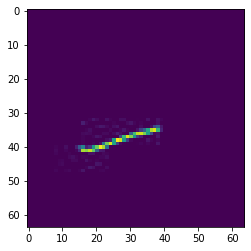

In [36]:
plt.imshow(x_train[6])
x_train.shape

In [37]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import InputLayer, Dense, Conv2D, BatchNormalization, Dropout, Flatten,LeakyReLU,MaxPool2D
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam

In [38]:
import keras_tuner as kt

In [39]:
def create_model(hp):
    model = keras.Sequential()
    model.add(InputLayer(input_shape=(64,64,1)))
    model.add(Conv2D(hp.Int("input_units",32,128,32),3,padding='same',activation='relu'))
    model.add(MaxPool2D())
    model.add(BatchNormalization())
    drop = hp.Choice('Dropout_rate',values=[0.1,0.2,0.3])
    model.add(Dropout(drop))
    
    for i in range(hp.Int('number_of_layers',1,3,1)):
        model.add(Conv2D(hp.Int("input_units1",64,256,32),3,padding='same',activation='relu'))

    model.add(MaxPool2D())
    model.add(BatchNormalization())
    model.add(Dropout(drop))
    model.add(Flatten())
    model.add(Dense(hp.Int('input_units2',512,1024,128),activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop))
    model.add(Dense(15))

    loss = SparseCategoricalCrossentropy(from_logits=True)
    opt = Adam(hp.Choice('lr',values=[1e-2, 1e-3, 1e-4]))

    model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])
    return model
    


In [40]:
tuner = kt.Hyperband(create_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='chinese_mnist')

In [41]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [42]:
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
The optimal number of input units for the first Conv2D layer is: {best_hps.get('input_units')},\n
The optimal dropout rate is: {best_hps.get('Dropout_rate')},\n
The optimal number of Conv layers after the first one is: {best_hps.get('number_of_layers')},\n
The optimal number of input units for those Conv2D layers is: {best_hps.get('input_units1')},\n
The optimal number of input units for Dense layer is: {best_hps.get('input_units2')},\n
The optimal learning rate is: {best_hps.get('lr')},\n
""")

Trial 30 Complete [00h 00m 36s]
val_accuracy: 0.8895833492279053

Best val_accuracy So Far: 0.98458331823349
Total elapsed time: 00h 11m 31s

The hyperparameter search is complete.
The optimal number of input units for the first Conv2D layer is: 96,

The optimal dropout rate is: 0.2,

The optimal number of Conv layers after the first one is: 3,

The optimal number of input units for those Conv2D layers is: 160,

The optimal number of input units for Dense layer is: 768,

The optimal learning rate is: 0.0001,




In [43]:
model = tuner.hypermodel.build(best_hps)

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 96)        960       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 96)        384       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 160)       138400    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 160)       230560    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 160)       2

In [46]:
history = model.fit(x_train,y_train,epochs=20,validation_split = 0.2,batch_size=128)

Epoch 1/20
75/75 [==============================] - 6s 66ms/step - loss: 0.1786 - accuracy: 0.9493 - val_loss: 2.4081 - val_accuracy: 0.2517
Epoch 2/20
75/75 [==============================] - 5s 63ms/step - loss: 0.1114 - accuracy: 0.9718 - val_loss: 1.9784 - val_accuracy: 0.3600
Epoch 3/20
75/75 [==============================] - 5s 62ms/step - loss: 0.0779 - accuracy: 0.9824 - val_loss: 1.3913 - val_accuracy: 0.5442
Epoch 4/20
75/75 [==============================] - 5s 62ms/step - loss: 0.0587 - accuracy: 0.9876 - val_loss: 0.7940 - val_accuracy: 0.7317
Epoch 5/20
75/75 [==============================] - 5s 62ms/step - loss: 0.0427 - accuracy: 0.9924 - val_loss: 0.3698 - val_accuracy: 0.8875
Epoch 6/20
75/75 [==============================] - 5s 62ms/step - loss: 0.0301 - accuracy: 0.9955 - val_loss: 0.2248 - val_accuracy: 0.9283
Epoch 7/20
75/75 [==============================] - 5s 62ms/step - loss: 0.0258 - accuracy: 0.9969 - val_loss: 0.1137 - val_accuracy: 0.9696
Epoch 8/20
75

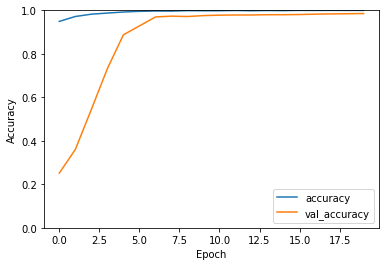

In [47]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

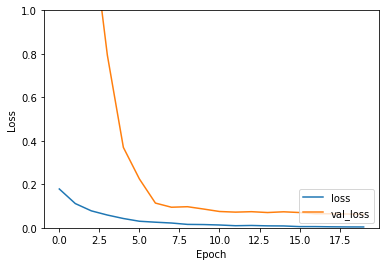

In [48]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [49]:
results = model.evaluate(x_test,y_test,batch_size=64)
print("test loss, test acc:", results)

47/47 [==============================] - 1s 16ms/step - loss: 0.0614 - accuracy: 0.9823
test loss, test acc: [0.06141331046819687, 0.9823333621025085]


In [50]:
predictions = model.predict(x_test)


In [51]:
subs = []
for p in predictions:
    subs.append(p.argmax())

In [52]:
results_df = pd.DataFrame({'ImageId' : range(1,3001), 'Label' : list(subs)})
results_df.head(10)
results_df.shape

(3000, 2)

In [53]:
results_df.to_csv("results.csv",index=False)